In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [3]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, transform=transform
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:25<00:00, 6.76MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:
# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_size, val_size

(40000, 10000)

In [13]:
for images, labels in train_loader:
    print(images.shape)  # e.g., torch.Size([100, 3, 32, 32])
    break

torch.Size([100, 3, 32, 32])


In [25]:
# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # flatten
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out


model = CNN().to(device)

In [26]:
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 256]       1,048,832
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 1,070,986
Trainable params: 1,070,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

In [53]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# For plots
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

writer = SummaryWriter("runs/cifar10_experiment")

# Training and Evaluation Loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_acc)

    # Log scalars
    writer.add_scalar("Loss/train", loss.item(), epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_acc, epoch)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] => "
        f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
        f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.2f}%"
    )

Epoch 1/10: 100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


Epoch [1/10] => Train Loss: 0.7944, Train Acc: 72.52%, Test Loss: 0.8095, Test Acc: 72.57%


Epoch 2/10: 100%|██████████| 500/500 [01:53<00:00,  4.41it/s]


Epoch [2/10] => Train Loss: 0.7746, Train Acc: 73.20%, Test Loss: 0.8467, Test Acc: 70.56%


Epoch 3/10: 100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


Epoch [3/10] => Train Loss: 0.7760, Train Acc: 72.98%, Test Loss: 0.7758, Test Acc: 73.12%


Epoch 4/10: 100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


Epoch [4/10] => Train Loss: 0.7645, Train Acc: 73.60%, Test Loss: 0.7833, Test Acc: 72.79%


Epoch 5/10: 100%|██████████| 500/500 [01:53<00:00,  4.40it/s]


Epoch [5/10] => Train Loss: 0.7617, Train Acc: 73.70%, Test Loss: 0.7487, Test Acc: 74.28%


Epoch 6/10: 100%|██████████| 500/500 [01:57<00:00,  4.26it/s]


Epoch [6/10] => Train Loss: 0.7525, Train Acc: 74.22%, Test Loss: 0.7532, Test Acc: 74.37%


Epoch 7/10: 100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


Epoch [7/10] => Train Loss: 0.7425, Train Acc: 74.37%, Test Loss: 0.7676, Test Acc: 74.29%


Epoch 8/10: 100%|██████████| 500/500 [01:55<00:00,  4.33it/s]


Epoch [8/10] => Train Loss: 0.7412, Train Acc: 74.41%, Test Loss: 0.7800, Test Acc: 73.54%


Epoch 9/10: 100%|██████████| 500/500 [01:59<00:00,  4.20it/s]


Epoch [9/10] => Train Loss: 0.7377, Train Acc: 74.52%, Test Loss: 0.7422, Test Acc: 74.54%


Epoch 10/10: 100%|██████████| 500/500 [02:01<00:00,  4.12it/s]


Epoch [10/10] => Train Loss: 0.7274, Train Acc: 75.06%, Test Loss: 0.7383, Test Acc: 74.19%


In [55]:
# ! tensorboard --logdir=runs

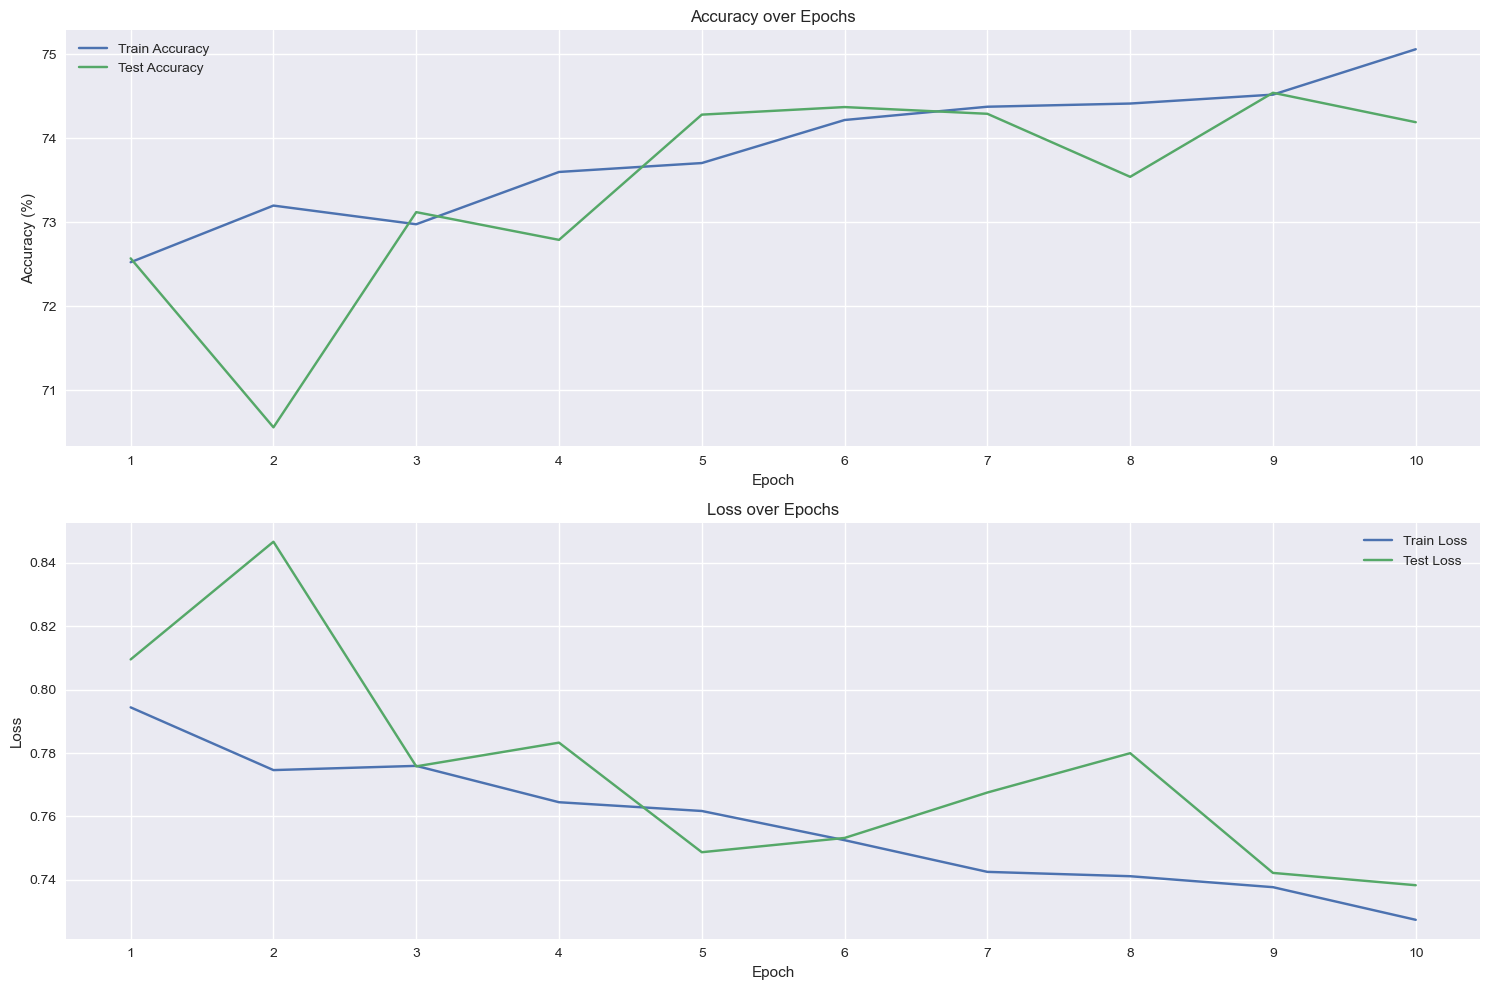

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# Create epoch range
epochs = list(range(1, len(train_accuracies) + 1))

# Plot Accuracy and Loss
plt.figure(figsize=(15, 10))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs)  # Optional: show all epoch ticks
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

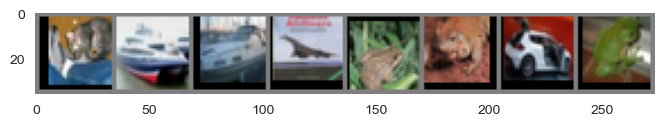

Predicted:  cat | ship | automobile | airplane | frog | frog | automobile | frog
Actual:     cat | ship | ship | airplane | frog | frog | automobile | frog


In [62]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize from (-1, 1) to (0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    plt.show()


# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Show images and predictions
imshow(torchvision.utils.make_grid(images.cpu()[:8]))
print("Predicted: ", " | ".join(f"{classes[predicted[j]]}" for j in range(8)))
print("Actual:    ", " | ".join(f"{classes[labels[j]]}" for j in range(8)))

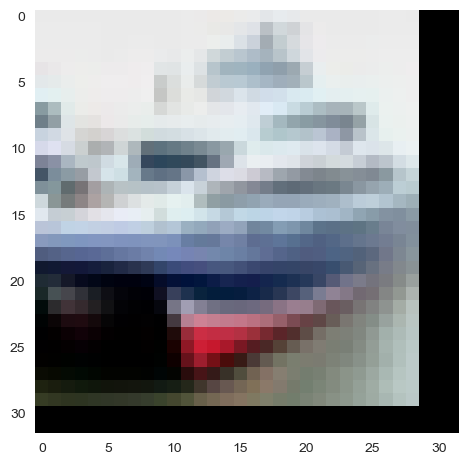

Predicted: automobile | Actual: ship


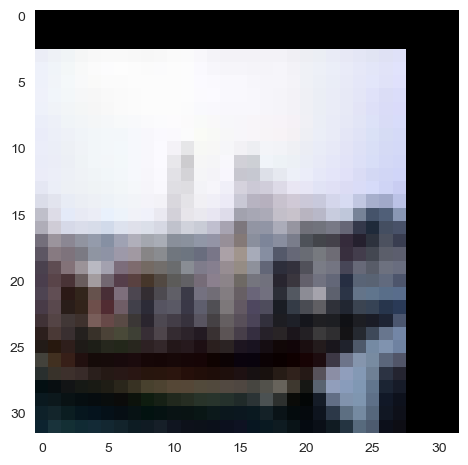

Predicted: truck | Actual: ship


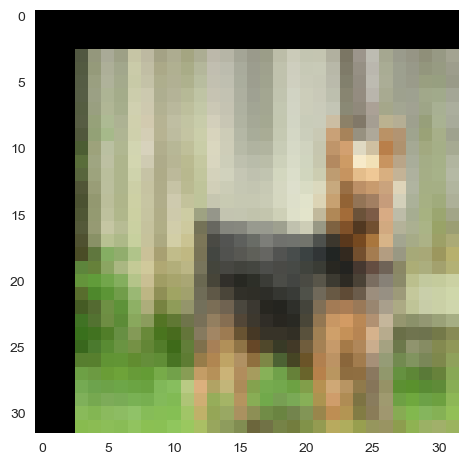

Predicted: deer | Actual: dog


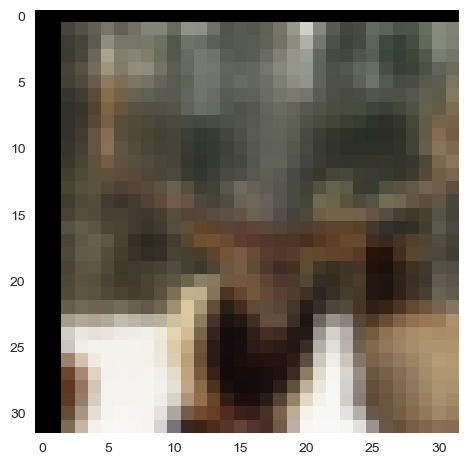

Predicted: cat | Actual: deer


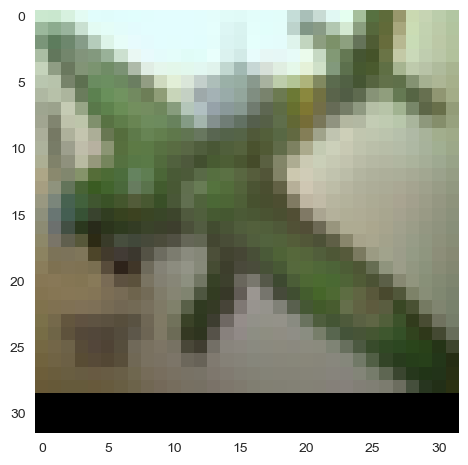

Predicted: bird | Actual: airplane


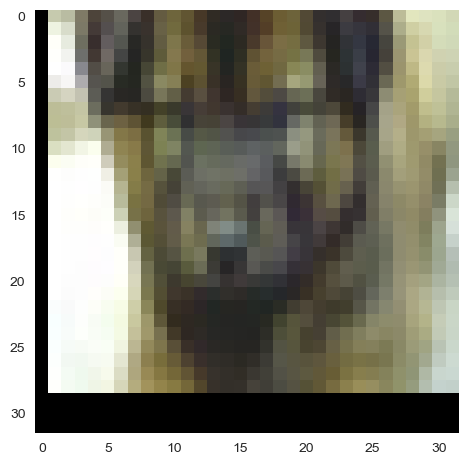

Predicted: cat | Actual: dog


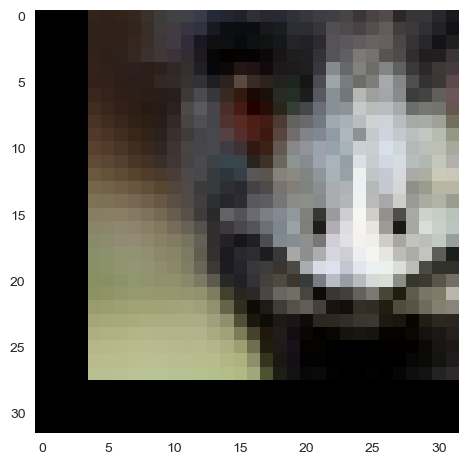

Predicted: automobile | Actual: bird


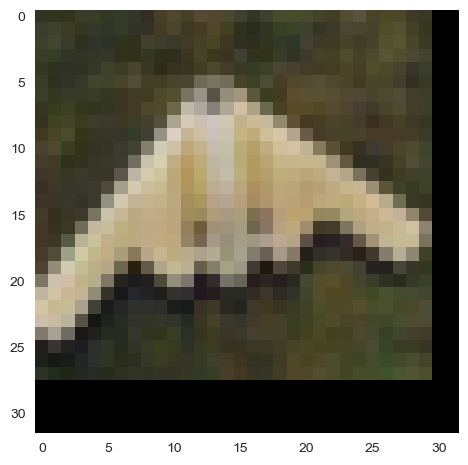

Predicted: horse | Actual: airplane


In [63]:
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified.append((img.cpu(), pred.cpu(), label.cpu()))
        if len(misclassified) >= 8:
            break

# Show first 8 misclassified images
for i in range(8):
    img, pred, label = misclassified[i]
    imshow(img)
    print(f"Predicted: {classes[pred]} | Actual: {classes[label]}")